In [89]:
# IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util.reselience_metrics import (
    EvalWindows,
    to_performance,
    compute_all,
)


In [ ]:
# === PATH TO YOUR RUN FILES (.npz) ===
PATH_PERT = "test_hangzhou/Ours_Normal_Block/1_step_metrics.npz"     # run WITH perturbation
PATH_BASE = "test_hangzhou/Ours_Normal_Normal/1_step_metrics.npz"              # control run WITHOUT perturbation

# time axis (must exist in BOTH files)
TIME_KEY = "t"

# Metric keys (one pair per performance metric you want to evaluate)
KEYMAP = {
    "speed":  ("speed", "speed"),        # (pert_key, base_key)
    "queue":  ("queue", "queue"),
    "wait":   ("wait", "wait"),
    "reward": ("ret", "ret"),
}

# Which metrics to evaluate in this run
SELECTED = ["speed", "queue", "wait"]  # or ["speed"] or add "reward" if meaningful

# === Windows (seconds or steps; must match your time units) ===
wins = EvalWindows(
    pre_start=0,  # start of pre-shock window
    t0=1200,         # shock start
    t1=2400,         # shock end
    post_end=3600    # end of evaluation horizon
)

# Normalization rule baked in our util:
# - higher_is_better=True  -> minmax
# - higher_is_better=False -> inv1p
DIRECTION = {
    "speed":  True,   # higher is better
    "reward": True,   # often higher is better (if your reward is aligned that way)
    "queue":  False,  # lower is better
    "wait":   False,  # lower is better
}

EPISODE = 1
SEED = 42
SEEDS = [42,43,44,45,46]

In [91]:
def array_to_series(t: np.ndarray, x: np.ndarray) -> pd.Series:
    """Create a pandas Series indexed by time/step."""
    return pd.Series(x, index=t).sort_index()

In [92]:
# Load files
pert = np.load(PATH_PERT,allow_pickle=True)
base = np.load(PATH_BASE,allow_pickle=True)
# Load the step log dict
pert = pert["step_log"].item()
base = base["step_log"].item()



In [93]:
all_rows = []
for seed in SEEDS:
    # Extract time axes for this seed
    t_pert = pert[seed][EPISODE][TIME_KEY]
    t_base = base[seed][EPISODE][TIME_KEY]
    # Build series per metric for this seed
    series_pert = {}
    series_base = {}
    for name in SELECTED:
        k_pert, k_base = KEYMAP[name]
        x_pert = pert[seed][EPISODE][k_pert]
        x_base = base[seed][EPISODE][k_base]
        series_pert[name] = array_to_series(t_pert, x_pert)
        series_base[name] = array_to_series(t_base, x_base)
    # Compute resilience metrics per selected metric
    for name in SELECTED:
        higher_is_better = DIRECTION[name]
        # 1) Normalize perturbed run into performance P(t)
        P = to_performance(
            series_pert[name],
            higher_is_better=higher_is_better,
            ref_window=wins.pre,
            allow_clip=False
        )
        # 2) Compute resilience metrics using baseline raw series
        res = compute_all(
            P, wins,
            baseline_raw=series_base[name],
            higher_is_better=higher_is_better,
            target=0.9,    # RT90
            band=0.05
        )
        res["metric"] = name
        res["seed"] = seed
        all_rows.append(res)
# Per-seed results (one row per seed × metric)
results_df = pd.DataFrame(all_rows).set_index(["metric","seed"]).sort_index()
display(results_df)

auc_ratio  peak_loss  rt_target  residual_delta
metric seed                                                 
queue  42     1.059994   0.169701        0.0        0.052399
       43     1.009618   0.264084        0.0        0.042042
       44     1.063172   0.181554        0.0        0.047621
       45     0.986013   0.284556        0.0        0.023628
       46     1.010447   0.226345        0.0        0.019499
speed  42     1.035178   0.347392        0.0        0.098767
       43     1.020616   0.380350        0.0        0.135981
       44     0.987074   0.373506        0.0        0.108451
       45     0.983926   0.484090        0.0        0.108897
       46     0.951486   0.429939        0.0        0.079699
wait   42     1.051932   0.290163        0.0        0.050683
       43     1.004715   0.409933       35.0        0.028920
       44     1.074134   0.240863        0.0        0.047294
       45     0.970031   0.371510        0.0        0.012820
       46     0.979814   0.342840        0.0       -0.006360

In [94]:
# Show mean ± std across seeds for each metric (speed / queue / wait)
summary = (results_df
           .groupby("metric")
           .agg(["mean","std"])
           .round(3))
display(summary)

auc_ratio        peak_loss        rt_target         residual_delta  \
            mean    std      mean    std      mean     std           mean   
metric                                                                      
queue      1.026  0.034     0.225  0.050       0.0   0.000          0.037   
speed      0.996  0.033     0.403  0.054       0.0   0.000          0.106   
wait       1.016  0.045     0.331  0.067       7.0  15.652          0.027   

               
          std  
metric         
queue   0.015  
speed   0.020  
wait    0.024

In [95]:
def plot_raw_overlay_simple(raw_pert, raw_base, wins, ylabel="", title=""):
    plt.figure(figsize=(15,8))
    plt.plot(raw_pert.index, raw_pert.values, label="Perturbed")
    plt.plot(raw_base.index, raw_base.values, label="Baseline")
    # shade perturbation window
    plt.axvspan(wins.t0, wins.t1, color="gray", alpha=0.3, label="Perturbation")
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

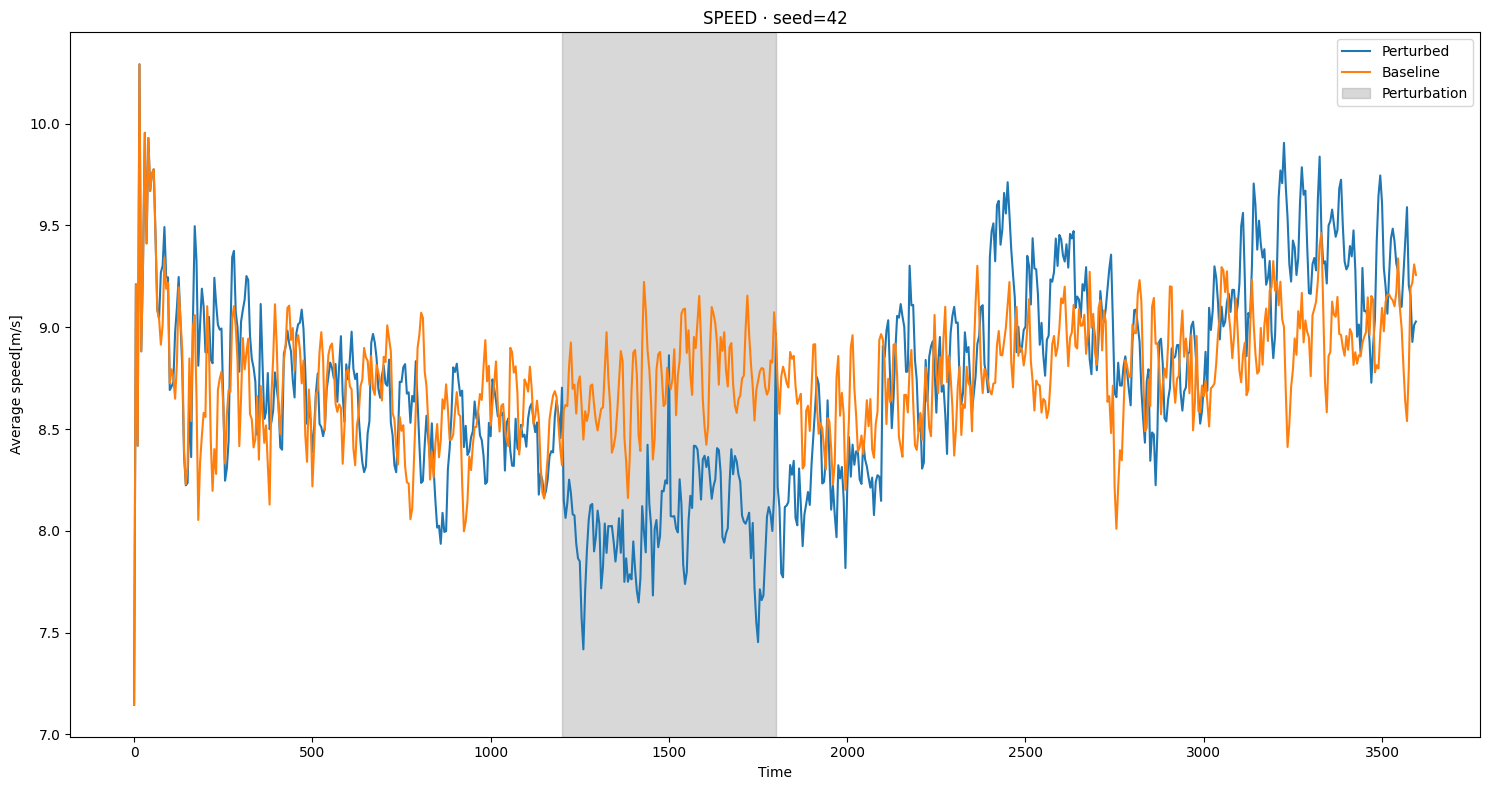

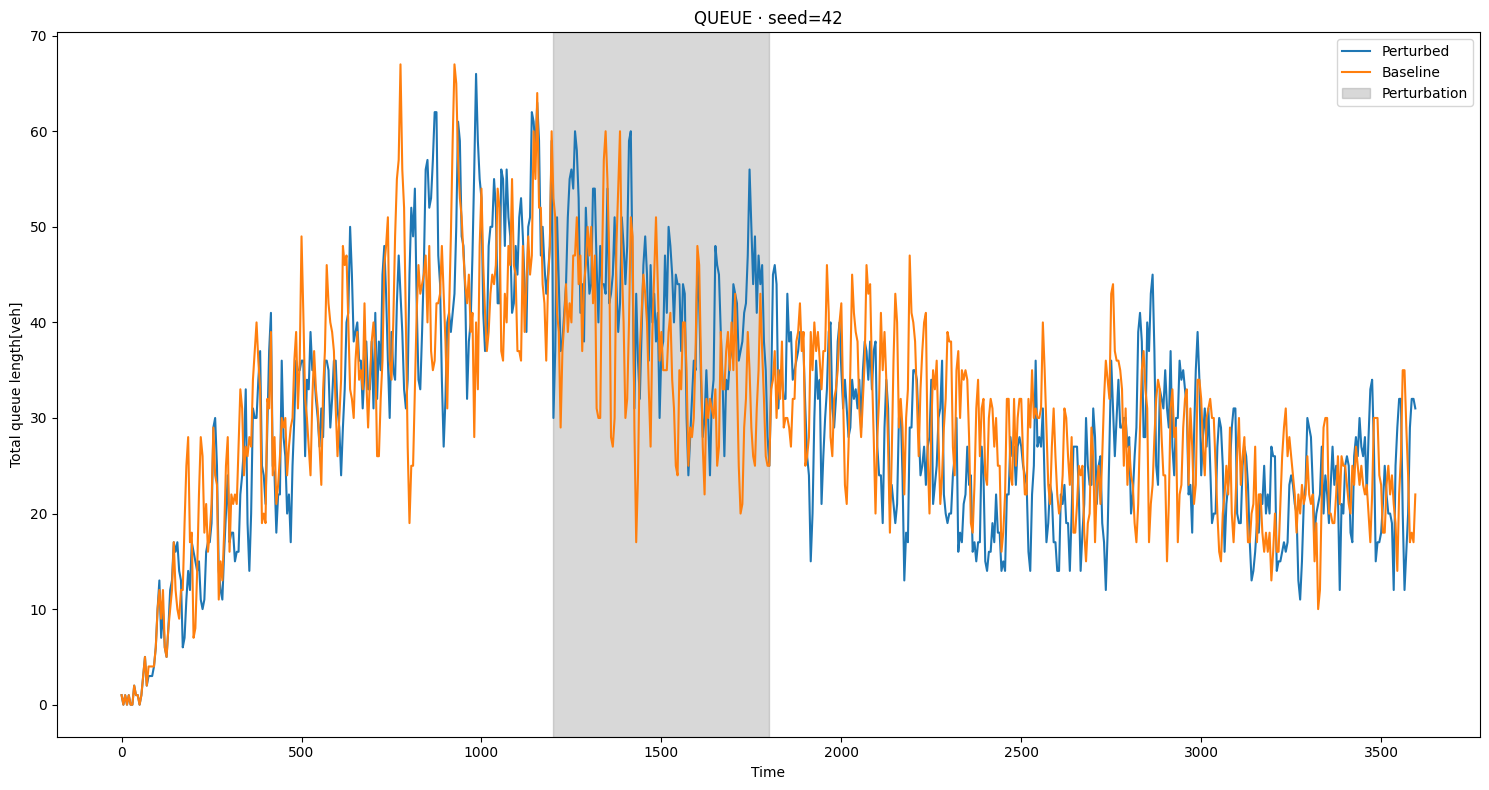

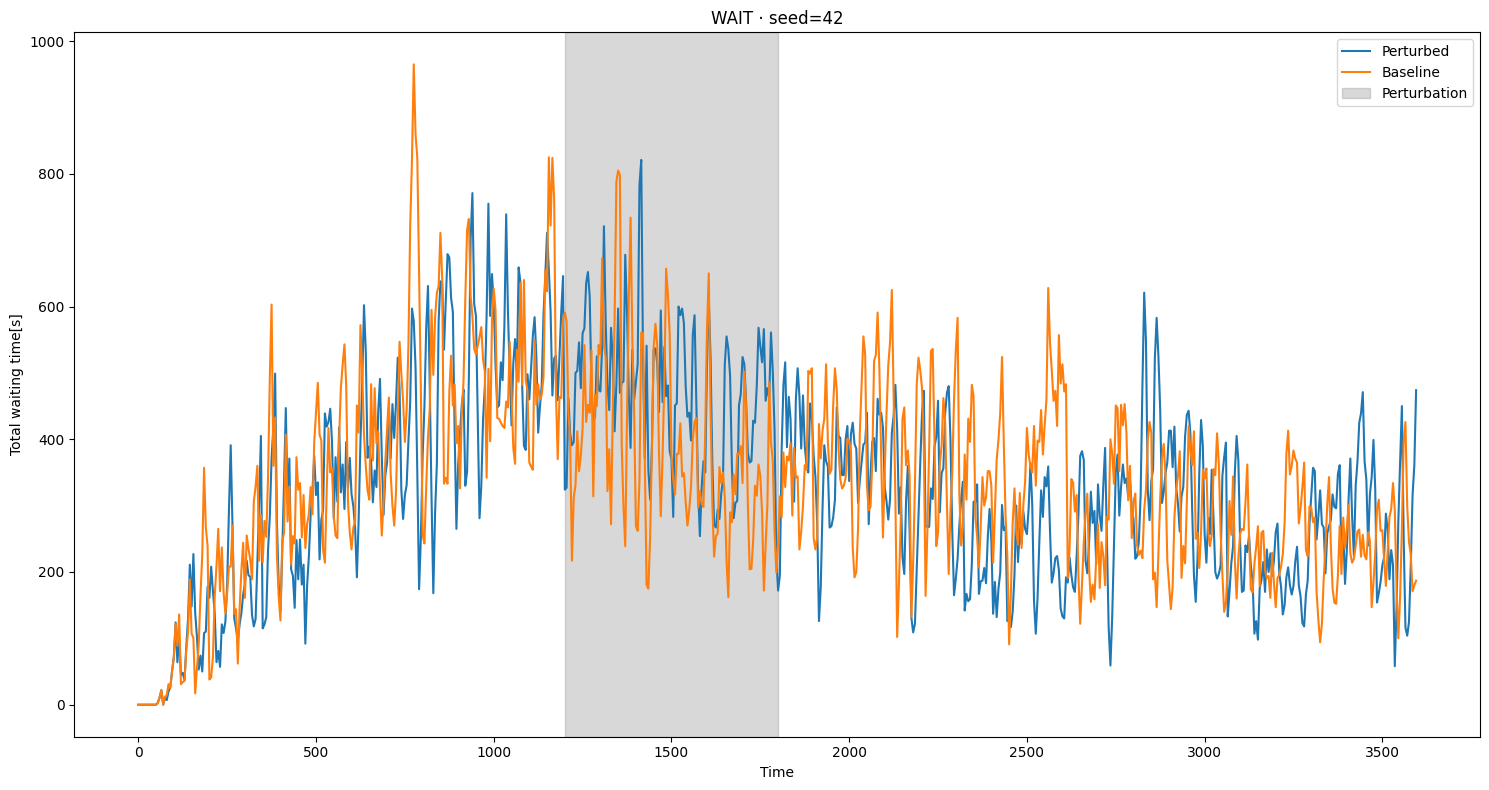

In [96]:
ylabels = {"speed": "Average speed[m/s]", "queue": "Total queue length[veh]", "wait": "Total waiting time[s]"}
for name in SELECTED:
    plot_raw_overlay_simple(
        series_pert[name],
        series_base[name],
        wins,
        ylabel=ylabels.get(name, name),
        title=f"{name.upper()} · seed={SEED}"
    )